# L'immobilier en californie

## Récupération des données

In [66]:
import os
import tarfile
import requests
from pathlib import Path

url = 'https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.tgz'
raw_housing_dir = 'datasets/raw'
raw_housing_compressed_file = 'housing.tgz'
raw_housing = 'housing'
raw_housing_data_path = '/'.join([raw_housing_dir, raw_housing, 'housing.csv'])


def load_dataset(url, dir_path, local_path_compressed, local_path):
    Path(dir_path).mkdir(parents=True, exist_ok=True)
    
    local_path_compressed = '/'.join([dir_path ,local_path_compressed])
    local_path = '/'.join([dir_path ,local_path])
    
    if not os.path.exists(local_path_compressed):
        response = requests.get(url, allow_redirects=True)
        with open(local_path_compressed, 'wb') as file:
            file.write(response.content)
            
    if not os.path.exists(local_path):
        tar = tarfile.open(local_path_compressed)
        tar.extractall(path=local_path)
        tar.close()
        
load_dataset(url, raw_housing_dir, raw_housing_compressed_file, raw_housing)

## Compréhenssion des données

In [67]:
import pandas as pd

housing = pd.read_csv(raw_housing_data_path)
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [68]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [69]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [70]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'housing_median_age'}>],
       [<AxesSubplot:title={'center':'total_rooms'}>,
        <AxesSubplot:title={'center':'total_bedrooms'}>,
        <AxesSubplot:title={'center':'population'}>],
       [<AxesSubplot:title={'center':'households'}>,
        <AxesSubplot:title={'center':'median_income'}>,
        <AxesSubplot:title={'center':'median_house_value'}>]],
      dtype=object)

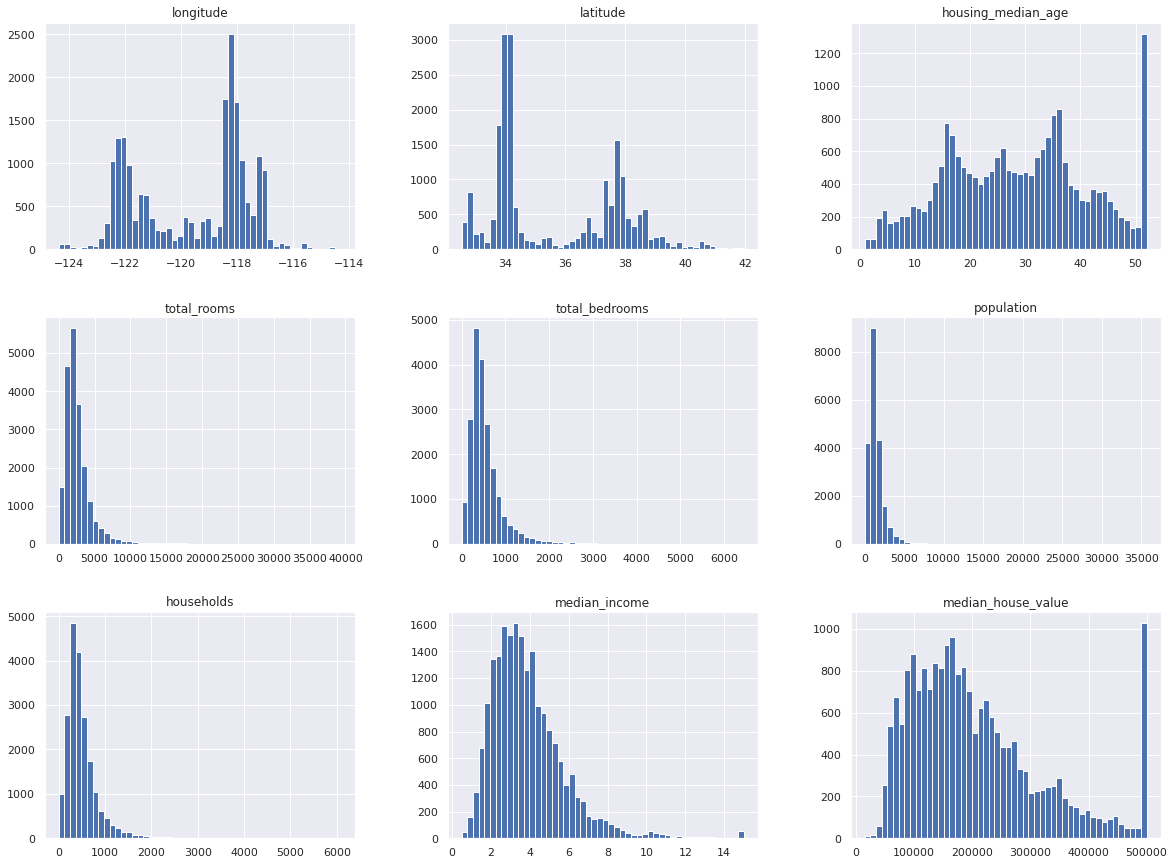

In [71]:
import seaborn as sns

sns.set_theme()

housing.hist(bins=50, figsize=(20, 15))

## Création du jeu de test

### Création d'une colonne id

In [72]:
housing_with_id = housing.copy()
housing_with_id['id'] = housing_with_id['longitude'] * 1000 + housing_with_id['latitude']

housing_with_id['id'].unique().shape

(12590,)

In [73]:
housing_with_id.shape

(20640, 11)

Les coordonées GPS des districts ne sont pas suffisamment discriminant. On se passera donc d'id.

### Echantillonage stratifié

On souhaite stratifier selon le revenu. On veut que notre jeu de test soit représentitatif du jeu total au niveau de la répartition des revenu médian.

On commence par créer une colonne pour les niveau de revenu

In [74]:
import numpy as np

# limitation du nombre de modalité
housing['income_cat'] = np.ceil(housing['median_income'] / 1.5)
housing['income_cat'].where(housing['income_cat'] < 5, 5.0, inplace=True)
housing['income_cat'].value_counts()

3.0    7236
2.0    6581
4.0    3639
5.0    2362
1.0     822
Name: income_cat, dtype: int64

<AxesSubplot:ylabel='Frequency'>

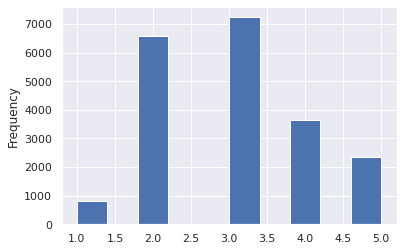

In [75]:
housing['income_cat'].plot.hist()

In [76]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=.2, random_state=314)
for train_idx, test_idx in split.split(housing, housing['income_cat']):
    train_set = housing.loc[train_idx]
    test_set = housing.loc[test_idx]
    
# proportions de chaque modalité dans le jeu de données complet
housing['income_cat'].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [77]:
# mêmes proportions dans le jeu de test
test_set['income_cat'].value_counts() / len(test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

In [78]:
# on remmet les données dans leur état d'origine

for dataset in (test_set, train_set):
    dataset.drop(columns=['income_cat'], inplace=True)

train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
12893,-121.33,38.65,23.0,2446.0,523.0,1132.0,513.0,2.6266,198500.0,INLAND
1460,-121.99,37.97,22.0,2823.0,509.0,1271.0,474.0,5.1333,207200.0,INLAND
18098,-122.04,37.33,22.0,4011.0,963.0,2206.0,879.0,4.5721,351200.0,<1H OCEAN
13361,-117.61,34.01,25.0,352.0,41.0,99.0,34.0,3.9696,500000.0,INLAND
6462,-118.06,34.10,42.0,1576.0,313.0,697.0,282.0,4.3523,283600.0,<1H OCEAN


## Visualisation des données

In [101]:
housing = train_set.copy()

### Recherche de corrélations entre variables

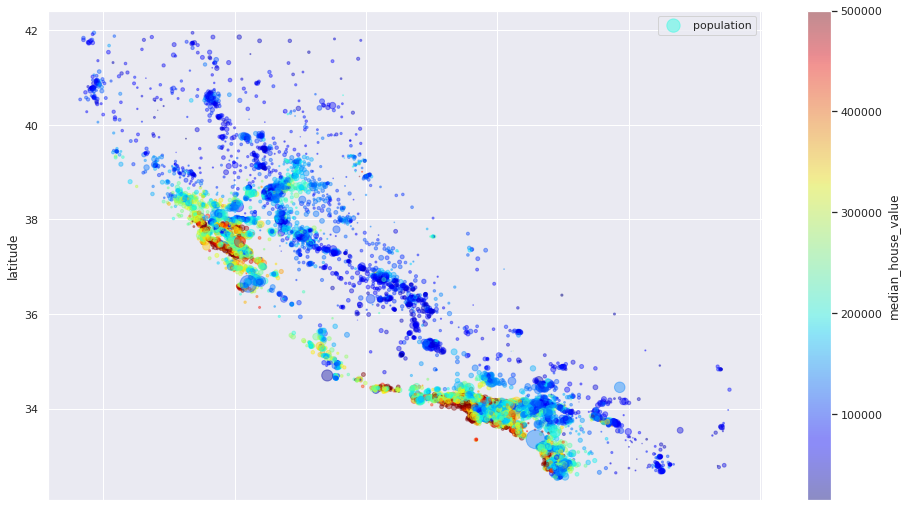

In [102]:
import matplotlib.pyplot as plt

housing.plot.scatter(x='longitude', y='latitude', alpha=.4, s=housing['population'] / 100,
                    c='median_house_value', label='population', figsize=(16, 9), cmap=plt.get_cmap('jet'),
                    colorbar=True)
plt.legend()

In [103]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688186
total_rooms           0.134226
housing_median_age    0.110175
households            0.066004
total_bedrooms        0.049260
population           -0.025461
longitude            -0.046004
latitude             -0.145520
Name: median_house_value, dtype: float64

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

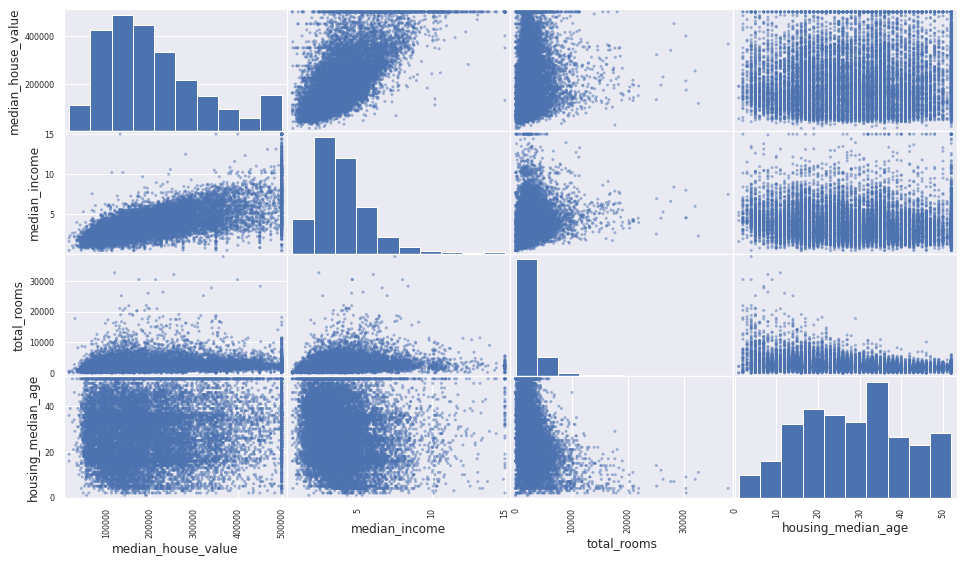

In [104]:
from pandas.plotting import scatter_matrix

cols = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[cols], figsize=(16, 9))

### Création de nouvelles variables

Avec pandas

In [83]:
# housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
# housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
# housing['population_per_household'] = housing['population'] / housing['households']

Avec un transformateur custom scikit learn

In [117]:
from  sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

class CombineAttributes(BaseEstimator, TransformerMixin):
    def __init__(self, indexes, add_bedrooms_per_room=True):
        self.indexes = indexes
        self.rooms_idx, self.bedrooms_idx, self.population_idx, self.household_idx = indexes
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, self.rooms_idx] / X[:, self.household_idx]
        population_per_household = X[:, self.population_idx] / X[:, self.household_idx]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, self.bedrooms_idx] / X[:, self.rooms_idx]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        return np.c_[X, rooms_per_household, population_per_household]
    
housing = train_set.copy()

combiner = CombineAttributes((3, 4, 5, 6))
new_cols = ['rooms_per_household', 'population_per_household', 'bedrooms_per_room']
housing = pd.DataFrame(combiner.transform(housing.values), columns=list(housing.columns) + new_cols)
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,population_per_household,bedrooms_per_room
0,-121.33,38.65,23.0,2446.0,523.0,1132.0,513.0,2.6266,198500.0,INLAND,4.768031,2.206628,0.213818
1,-121.99,37.97,22.0,2823.0,509.0,1271.0,474.0,5.1333,207200.0,INLAND,5.955696,2.681435,0.180305
2,-122.04,37.33,22.0,4011.0,963.0,2206.0,879.0,4.5721,351200.0,<1H OCEAN,4.56314,2.50967,0.24009
3,-117.61,34.01,25.0,352.0,41.0,99.0,34.0,3.9696,500000.0,INLAND,10.352941,2.911765,0.116477
4,-118.06,34.1,42.0,1576.0,313.0,697.0,282.0,4.3523,283600.0,<1H OCEAN,5.588652,2.471631,0.198604


In [84]:
housing.corr()['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688186
rooms_per_household         0.162686
total_rooms                 0.134226
housing_median_age          0.110175
households                  0.066004
total_bedrooms              0.049260
population_per_household   -0.022759
population                 -0.025461
longitude                  -0.046004
latitude                   -0.145520
bedrooms_per_room          -0.253423
Name: median_house_value, dtype: float64

## Préparation des données

In [85]:
# séparation features & labels

housing = train_set.drop(columns=['median_house_value'])
housing_labels = train_set.loc[:, 'median_house_value']

### Gestion des valeures manquantes

In [89]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
housing_num = housing.drop(columns=['ocean_proximity'])
X = imputer.fit_transform(housing_num)
housing_num_tr = pd.DataFrame(X, columns=housing_num.columns)

### Gestion des variables qualitatives

label encoding classique : on affect un nombre à chaque catégorie

In [90]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
housing_cat = housing.loc[:, 'ocean_proximity']
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

array([1, 1, 0, ..., 4, 1, 1])

In [91]:
encoder.classes_

array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)

Mais c'est pas top quand il n'y a pas de hiérarchie entre les catégories.

C'est pourquoi il vaut mieux utiliser du one hot encoding

In [93]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
housing_cat_1hot_encoded = encoder.fit_transform(housing_cat_encoded.reshape(-1, 1))
housing_cat_1hot_encoded

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [94]:
housing_cat_1hot_encoded.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

Il existe un moyen de faire les 2 étape en une seule

In [97]:
from sklearn.preprocessing import LabelBinarizer

encoder = LabelBinarizer(sparse_output=False)  # passer à True pour avoir une matrice creuse en sortie, 
                                               # ce qui prend moins de mémoire
housing_cat_1hot_encoded = encoder.fit_transform(housing_cat)
housing_cat_1hot_encoded

array([[0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0]])

### Recalibrage des variables et pipeline de transformation

In [129]:
train_set.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [139]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

class LabelBinarizerXy(LabelBinarizer):
    def fit(self, X, y=None):
        return super().fit(X)
    
    def fit_transform(self, X, y=None):
        return super().fit_transform(X)

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attrs_adder', CombineAttributes((3, 4, 5, 6))),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('cat_encoder', LabelBinarizerXy()),
])

housing_cat_cols = ['ocean_proximity']
housing_num_cols = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income']
features_cols = housing_num_cols + housing_cat_cols
labels_cols = ['median_house_value']

full_pipeline = ColumnTransformer([
    ('num_pipeline', num_pipeline, housing_num_cols),
    ('cat_pipline', cat_pipeline, housing_cat_cols)
])

housing_tr = full_pipeline.fit_transform(train_set[features_cols])
housing_tr

array([[-0.87315416,  1.40373866, -0.4430182 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.20219964,  1.08637661, -0.52236044, ...,  0.        ,
         0.        ,  0.        ],
       [-1.22712733,  0.78768291, -0.52236044, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.07048261, -0.57510707,  0.50908869, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.0242426 ,  0.53099302, -0.68104493, ...,  0.        ,
         0.        ,  0.        ],
       [-0.94295169,  1.33373232, -0.91907165, ...,  0.        ,
         0.        ,  0.        ]])

In [140]:
print(housing_tr.shape)
housing_tr[0]

(16512, 16)


array([-8.73154160e-01,  1.40373866e+00, -4.43018203e-01, -8.27007136e-02,
       -2.76099645e-02, -2.55013777e-01,  4.13994040e-02, -6.54010086e-01,
       -2.79415254e-01, -7.69864855e-02,  5.46804114e-04,  0.00000000e+00,
        1.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

## Sélection et entrainement d'un modèle

### Régression linéaire

In [141]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_tr, train_set[labels_cols].values)

LinearRegression()

In [146]:
sample_features = train_set.loc[:, features_cols].iloc[:5]
sample_labels = train_set.loc[:, labels_cols].iloc[:5]

sample_tr = full_pipeline.transform(sample_features)
sample_preds = lin_reg.predict(sample_tr)

In [156]:
sample_preds = pd.DataFrame(sample_preds)
pd.concat([sample_labels.reset_index(drop=True), sample_preds], axis=1)

,median_house_value,0
0,198500.0,105984.0
1,207200.0,227168.0
2,351200.0,283776.0
3,500000.0,159808.0
4,283600.0,248800.0


On estime la qualité du modèle avec la RMSE

In [159]:
from sklearn.metrics import mean_squared_error

housing_preds = lin_reg.predict(housing_tr)
lin_mse = mean_squared_error(train_set[labels_cols], housing_preds)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68204.35971105352

### Régression avec un arbre de décision

In [161]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_tr, train_set[labels_cols].values)

DecisionTreeRegressor()

In [162]:
tree_preds = tree_reg.predict(housing_tr)
tree_rmse = np.sqrt(mean_squared_error(train_set[labels_cols], tree_preds))
tree_rmse

0.0

Le modèle surajuste les données.

C'est assez logique : on évalue le modèle sur les mêmes données qui ont servies à l'entrainer !

### Validation croisée

In [165]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_tr, train_set[labels_cols],
                        scoring='neg_mean_squared_error', cv=10)
# cette fonction demande une fonction d'utilité, et non une fonction de cout
# la diff entre les 2 c'est que l'on cherche à maximiser la fonction d'utilité
# là où l'on cherchait à minimiser la fonction de coût
# c'est pour ça le "-" avant le "score" :
tree_rmse_scores = np.sqrt(-scores)

In [167]:
print(tree_rmse_scores)
print(tree_rmse_scores.mean())
print(tree_rmse_scores.std())

[69971.34148509 73290.46077657 68831.14397051 69959.65622597
 74736.42348088 68188.56009158 71579.40756311 68992.05066381
 70671.85119683 68462.41357217]
70468.33090265142
2050.452028872047


Validation croisée du modèle linéaire :

In [168]:
lin_scores = cross_val_score(lin_reg, housing_tr, train_set[labels_cols],
                        scoring='neg_mean_squared_error', cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
print(lin_rmse_scores)
print(lin_rmse_scores.mean())
print(lin_rmse_scores.std())

[67736.34217226 68188.50679455 65194.67773599 67858.20372059
 69444.14653896 68781.76268292 66571.89886093 68586.31463326
 73423.56830818 68531.42127942]
68431.68427270514
2022.5955586629098


### Forêt aléatoires

In [169]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_tr, train_set[labels_cols])

<ipython-input-169-4b00e0d1c71c>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest_reg.fit(housing_tr, train_set[labels_cols])


RandomForestRegressor()

In [170]:
forest_scores = cross_val_score(forest_reg, housing_tr, train_set[labels_cols],
                        scoring='neg_mean_squared_error', cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
print(forest_rmse_scores)
print(forest_rmse_scores.mean())
print(forest_rmse_scores.std())

/home/thomas/miniconda3/envs/housing/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/thomas/miniconda3/envs/housing/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/thomas/miniconda3/envs/housing/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/thomas/miniconda3/envs/housing/lib/python3.8/site-packages

[50346.25045642 52615.53378708 49039.26231575 50745.05774709
 50457.66507361 50853.4526547  50384.29000727 50147.72301354
 49037.1224293  50442.62484836]
50406.89823331408
949.408353449241


### Savegarde des modèles

In [172]:
import joblib

joblib.dump(lin_reg, 'models/lin_reg.pkl')

['models/lin_reg.pkl']

In [173]:
joblib.dump(tree_reg, 'models/tree_reg.pkl')

['models/tree_reg.pkl']

In [174]:
joblib.dump(forest_reg, 'models/forest_reg.pkl')

['models/forest_reg.pkl']

Pour réutiliser les modèles :

In [175]:
lin_reg = joblib.load('models/lin_reg.pkl')

## Ajuster les hyperparamètres

In [176]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'n_estimators': [3, 10], 'max_features': [2, 3, 4], 'bootstrap': [False]},
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(housing_tr, train_set[labels_cols])

/home/thomas/miniconda3/envs/housing/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/thomas/miniconda3/envs/housing/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/thomas/miniconda3/envs/housing/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/thomas/miniconda3/envs/housing/lib/python3.8/site-packages

/home/thomas/miniconda3/envs/housing/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/thomas/miniconda3/envs/housing/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/thomas/miniconda3/envs/housing/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/thomas/miniconda3/envs/housing/lib/python3.8/site-packages

/home/thomas/miniconda3/envs/housing/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/thomas/miniconda3/envs/housing/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/thomas/miniconda3/envs/housing/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/thomas/miniconda3/envs/housing/lib/python3.8/site-packages

/home/thomas/miniconda3/envs/housing/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/thomas/miniconda3/envs/housing/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/thomas/miniconda3/envs/housing/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/thomas/miniconda3/envs/housing/lib/python3.8/site-packages

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             scoring='neg_mean_squared_error')

In [177]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [178]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30)

In [182]:
cv_res = grid_search.cv_results_
for mean_score, params in zip(cv_res['mean_test_score'], cv_res['params']):
    print('score = {} ; params: {}'.format(np.sqrt(-mean_score), params))

score = 63537.71888819469 ; params: {'max_features': 2, 'n_estimators': 3}
score = 55774.101437991776 ; params: {'max_features': 2, 'n_estimators': 10}
score = 52898.512988216644 ; params: {'max_features': 2, 'n_estimators': 30}
score = 59929.93355803825 ; params: {'max_features': 4, 'n_estimators': 3}
score = 52897.442658666834 ; params: {'max_features': 4, 'n_estimators': 10}
score = 50622.0379869694 ; params: {'max_features': 4, 'n_estimators': 30}
score = 59002.002996679104 ; params: {'max_features': 6, 'n_estimators': 3}
score = 52178.658328645644 ; params: {'max_features': 6, 'n_estimators': 10}
score = 50050.064477807464 ; params: {'max_features': 6, 'n_estimators': 30}
score = 58713.031761072045 ; params: {'max_features': 8, 'n_estimators': 3}
score = 52496.99022480393 ; params: {'max_features': 8, 'n_estimators': 10}
score = 50562.52456766506 ; params: {'max_features': 8, 'n_estimators': 30}
score = 62365.50546505392 ; params: {'bootstrap': False, 'max_features': 2, 'n_estimat

In [183]:
forest_reg = RandomForestRegressor(**grid_search.best_params_)
forest_reg.fit(housing_tr, train_set[labels_cols])
joblib.dump(forest_reg, 'models/forest_reg.pkl')

<ipython-input-183-3d502942e8ec>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest_reg.fit(housing_tr, train_set[labels_cols])


['models/forest_reg.pkl']

### Analyser le meilleur modèle

In [184]:
feature_importance = forest_reg.feature_importances_
feature_importance

array([7.63962799e-02, 6.97385579e-02, 3.77411101e-02, 1.89680725e-02,
       1.56454460e-02, 1.79813050e-02, 1.56926293e-02, 3.52081887e-01,
       5.83653674e-02, 1.02882189e-01, 5.68107288e-02, 1.36690803e-02,
       1.58592009e-01, 1.79239629e-04, 1.64424766e-03, 3.61185045e-03])

In [196]:
all_cols = (housing_num_cols 
            + ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room'] 
            + list(full_pipeline.transformers_[1][1]['cat_encoder'].classes_))
sorted(zip(feature_importance, all_cols), reverse=True)

[(0.35208188719777606, 'median_income'),
 (0.15859200940388887, 'INLAND'),
 (0.10288218850940532, 'pop_per_hhold'),
 (0.07639627989999467, 'longitude'),
 (0.06973855786229109, 'latitude'),
 (0.058365367382952844, 'rooms_per_hhold'),
 (0.05681072881316332, 'bedrooms_per_room'),
 (0.037741110086316344, 'housing_median_age'),
 (0.018968072515661263, 'total_rooms'),
 (0.01798130497505444, 'population'),
 (0.015692629315368287, 'households'),
 (0.015645446013768247, 'total_bedrooms'),
 (0.013669080281487488, '<1H OCEAN'),
 (0.0036118504529898585, 'NEAR OCEAN'),
 (0.001644247660449307, 'NEAR BAY'),
 (0.00017923962943261303, 'ISLAND')]

## Evaluation finale sur le jeu de test

In [199]:
X_test = test_set[features_cols].copy()
y_test = test_set.loc[:, 'median_house_value'].values

X_test_tr = full_pipeline.transform(X_test)

test_preds = forest_reg.predict(X_test_tr)

rmse = np.sqrt(mean_squared_error(y_test, test_preds))
rmse

47897.08398275354